# Курс "Вычислительная математика"
# 3 курс ФПМИ МФТИ, весна 2025
## Практическое задание №5. Преобразование Фурье

In [ ]:
import math
import time

import numpy as np
import numpy.fft as npf

from scipy import stats as sps
from scipy import fft as spf
from scipy.integrate import quad

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

import numba

from tqdm import tqdm

sns.set(font_scale=1.4, style='whitegrid')
%config InlineBackend.figure_format='retina'

## Дискретное преобразование Фурье


In [ ]:
def time_discretization(a, b, N):
    return np.linspace(a, b, N, endpoint=True)


def func_discretization(func, a, b, N):
    x = time_discretization(a, b, N)
    return x, func(x)

### Реализация дискретного преобразования Фурье (прямого и обратного)

In [ ]:
def DFT(x):
    N = len(x)
    X = np.zeros(N, dtype=complex)

    @numba.jit
    def _calc(X):
        for k in range(N):
            for n in range(N):
                X[k] += x[n] * np.exp(-2j * np.pi * k * n / N)

    _calc(X)
    return X

def IDFT(X, M):
    N = len(X)
    y = np.zeros(M, dtype=complex)

    @numba.jit
    def _calc(y):
        for m in range(M):
            for k in range(N):
                y[m] += X[k] * np.exp(2j * np.pi * k * m / M)
            y[m] /= N

    _calc(y)
    return y.real


# numba compilation
DFT(np.exp(time_discretization(0, 1, 10)))
IDFT(np.exp(time_discretization(0, 1, 10)), 10);

### Реализация быстрого дискретного преобразования Фурье (прямого и обратного)

In [ ]:
#TODO

### Оценка качества функции: численные своойства

**Оценку качества будем делать таким методом**: восстановим функцию по более плотной сетке при помощи вычисления ряда Фурье и оценим ошибку по отношению к исходной функции

In [ ]:
def fourier_coef(y, N_terms=None, fft=DFT, warning=True):
    """Вычисляет коэффициенты ряда Фурье для функции"""
    N = len(y)
    if N_terms is None:
        N_terms = N//3
    if N_terms >= N//2 and warning:
        # Максимум по теореме Котельникова
        print("Aliasing problem")

    fft_coeffs = fft(y) / N

    a0 = 2 * fft_coeffs[0].real
    an = 2 * fft_coeffs[1:N_terms+1].real
    bn = -2 * fft_coeffs[1:N_terms+1].imag

    return a0, an, bn


def fourier_reconstruct(x, a0, an, bn, a, b):
    """Восстанавливает сигнал по коэффициентам Фурье для интервала длины period"""
    x -= a
    x *= 1/(b-a)

    result = a0/2
    for i in range(len(an)):
        n = i+1

        omega = 2*np.pi*n
        result += an[i]*np.cos(a+omega*x) + bn[i]*np.sin(a+omega*x)
    return result

#### Простой пример

Данные для эксперимента.

In [ ]:
func = lambda x: np.sin(3*x) + 0.5*np.cos(5*x)
a, b = -np.pi, np.pi
N = 1000

_, y = func_discretization(func, a, b, N)

ДПФ: получаем коэффиценты ряда Фурье.

In [ ]:
a0, an, bn = fourier_coef(y)

Используем коэффиценты для вычисления ряда Фурье на более плотной сетке.

In [ ]:
x = time_discretization(a, b, N*100)
y_reconstruct = fourier_reconstruct(x, a0, an, bn, a, b)

Оценка ошибки.

In [ ]:
print(f"mse: {np.mean((func(x)+y_reconstruct)**2)}")

mse: 0.00013000821850012073


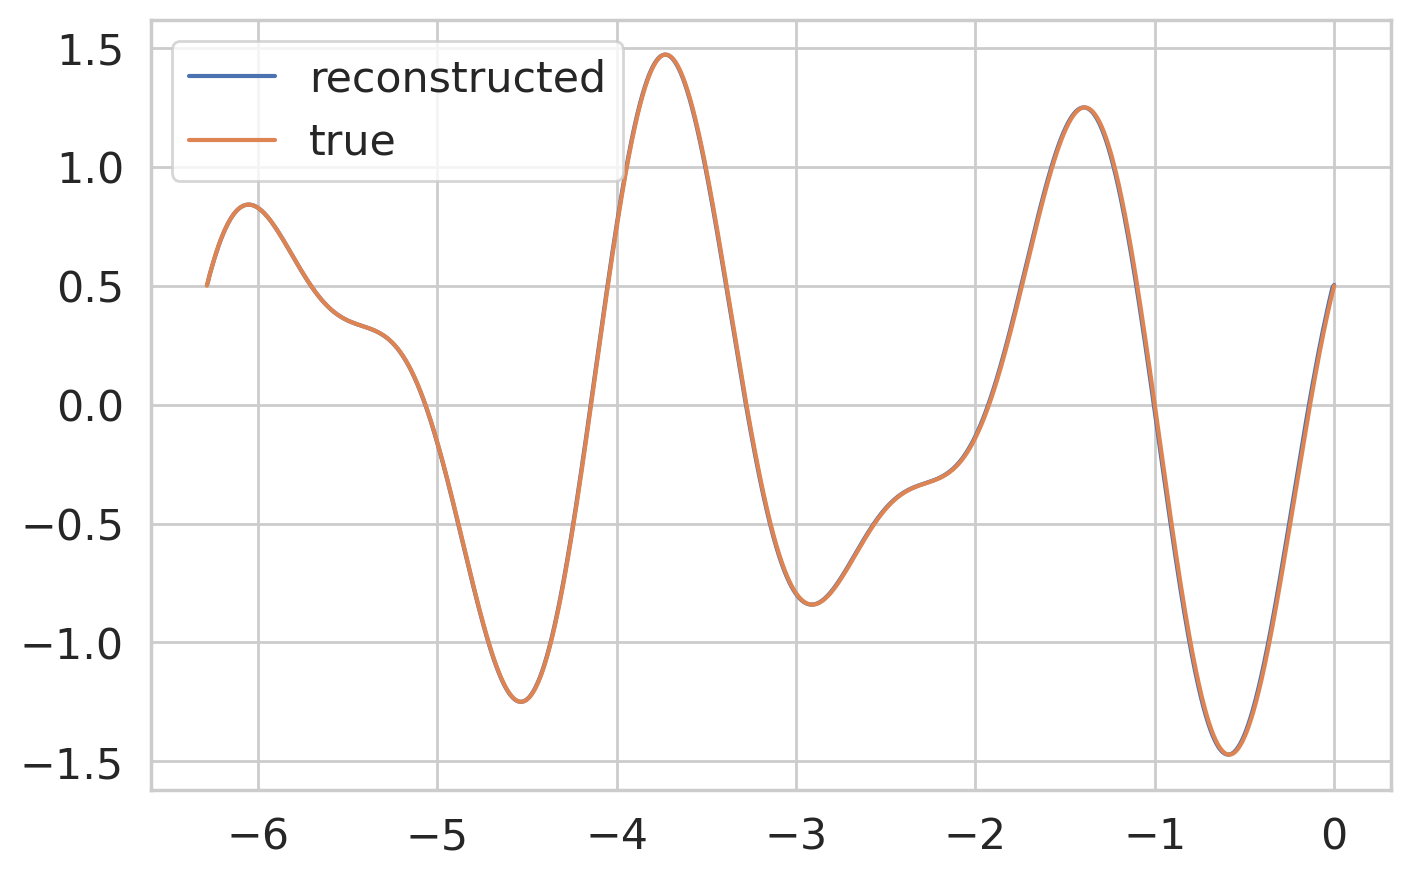

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(x, -y_reconstruct, label="reconstructed")
plt.plot(x, func(x), label="true")

plt.legend()
plt.show()

#### Рассмотрим убывание ошибки с ростом частоты дискретизации.

In [ ]:
def calc_fourier_reconstruct_error(func, a, b, N, M, N_terms=None, plot=False, warning=True):
    _, y = func_discretization(func, a, b, N)

    a0, an, bn = fourier_coef(y, N_terms, warning=warning)

    x = time_discretization(a, b, M)
    y_reconstruct = fourier_reconstruct(x, a0, an, bn, a, b)

    if plot:
        print(a, b)
        plt.plot(x, func(x), label="true")
        plt.plot(x, y_reconstruct, label="fourier_reconstruct")

    return np.mean((y_reconstruct - func(x))**2)

SyntaxError: invalid syntax (<ipython-input-194-448619d4d43c>, line 9)

In [ ]:
n_range = np.arange(10, 10**3+1, 10)

mse = [
    calc_fourier_reconstruct_error(lambda x: np.exp(x) + np.exp(1-x), 0, 1, n, 10**4)
    for n in tqdm(n_range)
]

100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


Визуализация

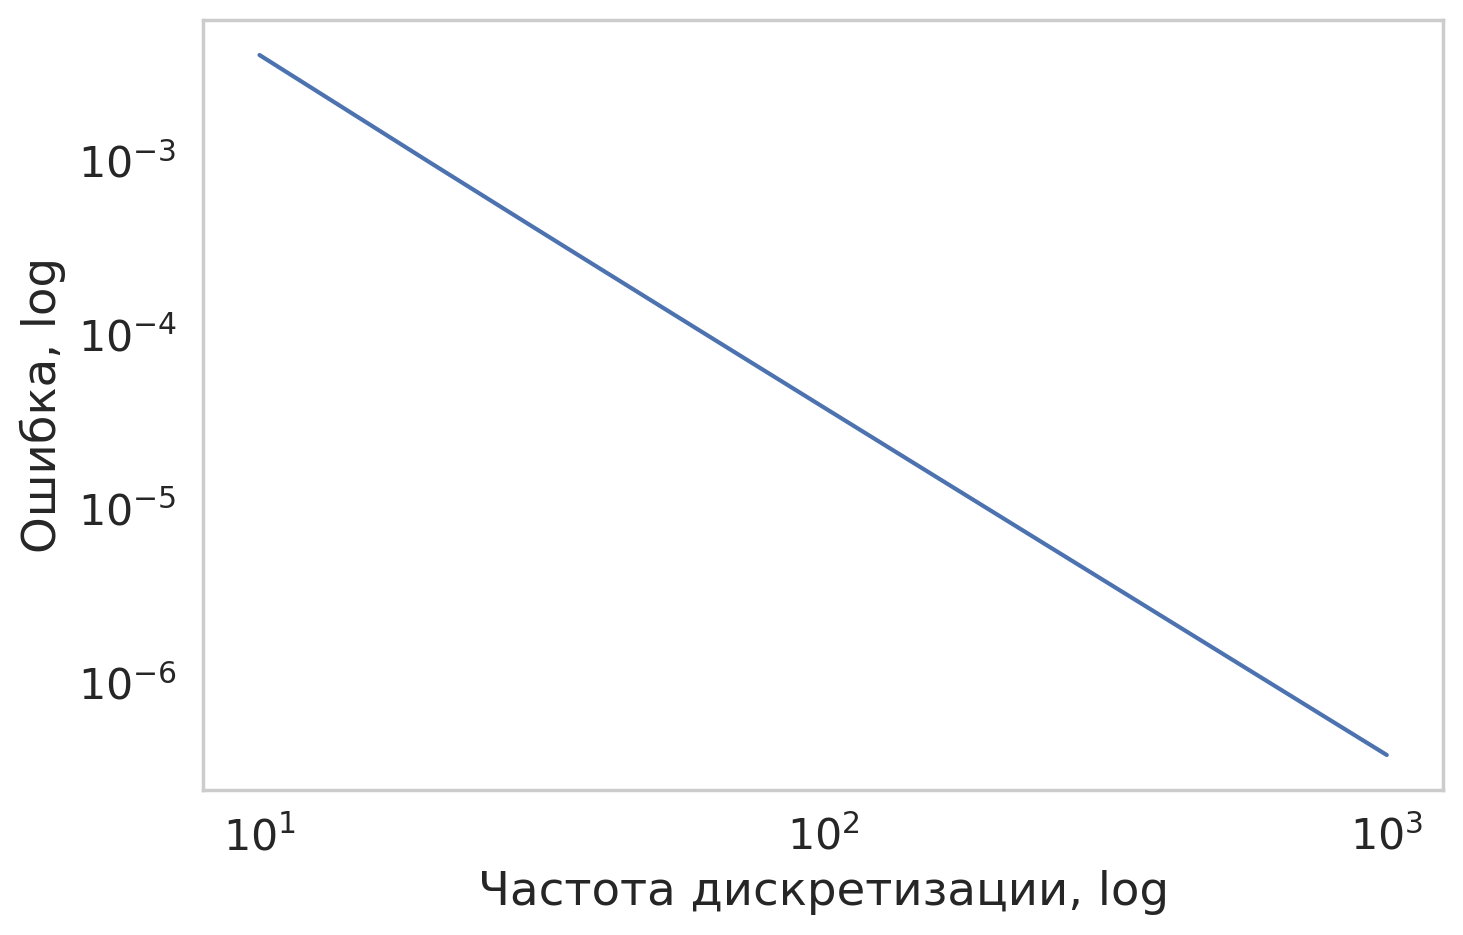

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(n_range, mse)

plt.ylabel("Ошибка, log")
plt.xlabel("Частота дискретизации, log")

plt.xscale("log")
plt.yscale("log")

plt.grid(False)
plt.show()

### Оценка качества функции: временная эффективность

In [ ]:
t = []
n_range = np.linspace(10**2, 10**4, 100)

for n in tqdm(n_range):
    start = time.time()
    DFT(np.exp(time_discretization(0, 1, n)))
    t.append(time.time() - start)

  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [ ]:
plt.plot(n_range, t)
plt.show()

In [ ]:
t = []
n_range = np.linspace(10**2, 10**4, 10**4)

for n in tqdm(n_range):
    start = time.time()
    spf.fft(np.exp(time_discretization(0, 1, n)))
    t.append(time.time() - start)

  0%|          | 0/10000 [00:00<?, ?it/s]


TypeError: 'numpy.float64' object cannot be interpreted as an integer

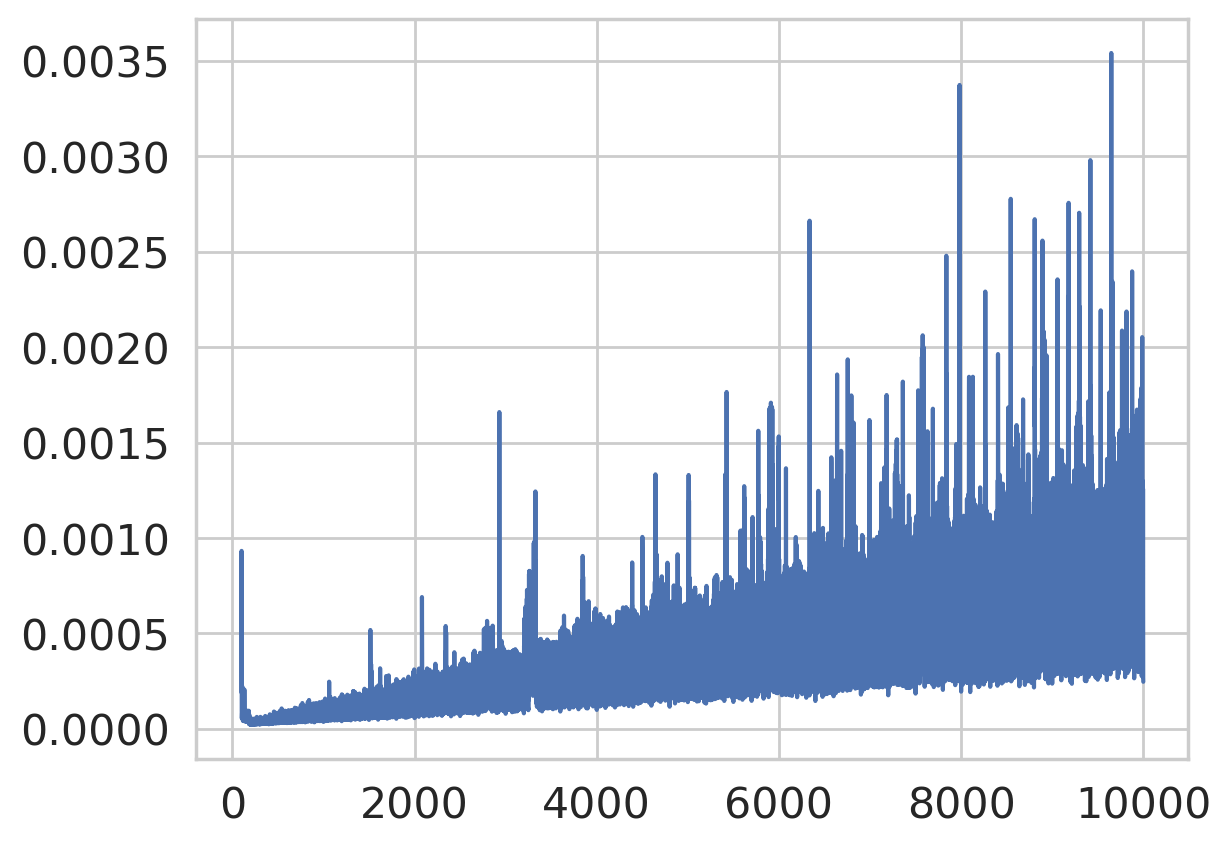

In [ ]:
plt.plot(n_range, t)
plt.show()

## Эффект алиасинга и численная проверка теоремы Котельникова

### Эффект алиасинга

> Эффект алиасинга (или наложение частот) - это искажение сигнала, возникающее при неправильной дискретизации, когда частота дискретизации (количество отсчетов в секунду) недостаточна для точного представления высокочастотных компонентов сигнала. Это приводит к тому, что высокие частоты "маскируются" под низкие, создавая ложные артефакты.

_Chat GPT_


In [ ]:
Fs = 10  # Частота дискретизации (Гц)
t = time_discretization(0, 10, Fs)

y1 = lambda x: np.sin(2*np.pi*x)
y2 = lambda x: np.sin(2*np.pi*x*0.1)

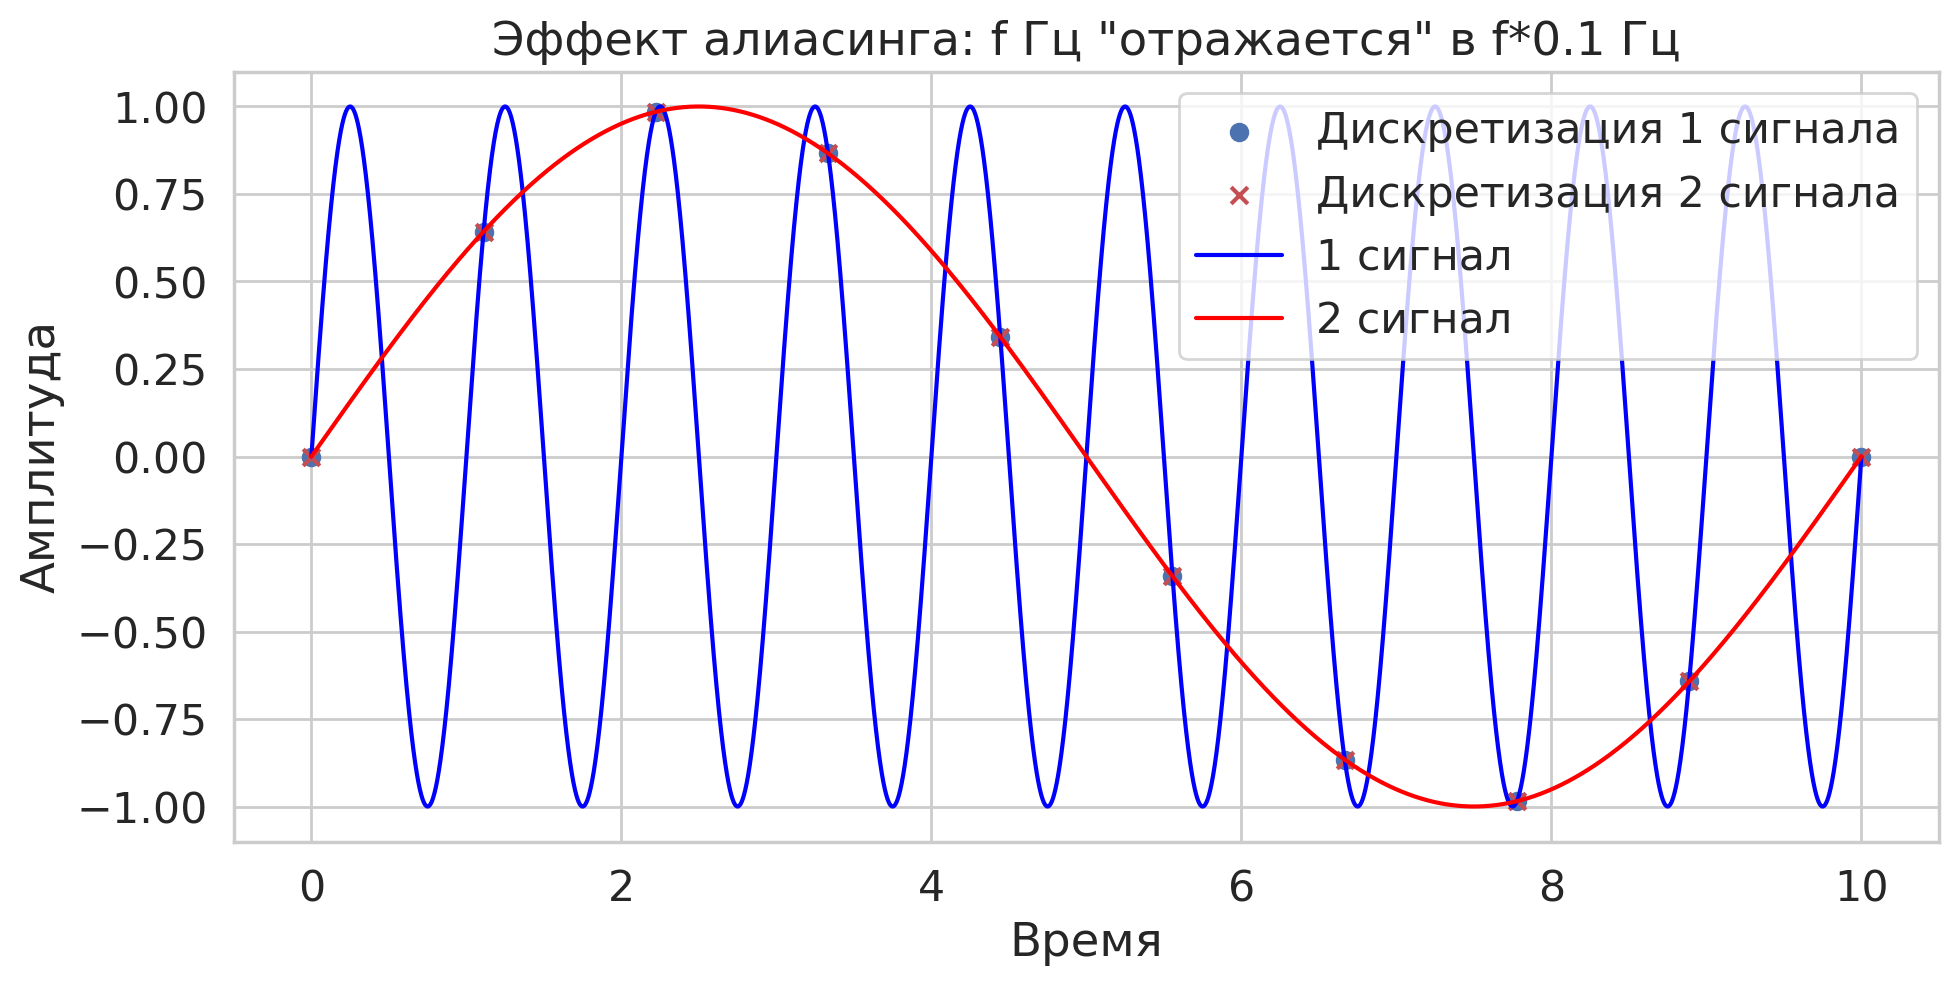

In [ ]:
plt.figure(figsize=(11, 5))

plt.scatter(t, y1(t), color='b', marker="o", label="Дискретизация 1 сигнала")
plt.scatter(t, y2(t), color='r', marker="x", label="Дискретизация 2 сигнала")

x = time_discretization(0, 10, 10**4)

plt.plot(x, y1(x), color='blue', label="1 сигнал")
plt.plot(x, y2(x), color='red', label="2 сигнал")

plt.title('Эффект алиасинга: f Гц "отражается" в f*0.1 Гц')
plt.xlabel('Время')
plt.ylabel('Амплитуда')

plt.legend()
plt.grid(True)
plt.show()

### Проверка теоремы Котельникова

__Теорема Котельникова (Найквиста-Шеннона)__

Чтобы точно восстановить сигнал, частота дискретизации должна быть как минимум в 2 раза выше максимальной частоты в спектре сигнала:
$$    F_s > 2F_{max​} $$

In [ ]:
f_range = np.arange(10, 100)

mse = [
    calc_fourier_reconstruct_error(lambda x: np.sin(2 * np.pi * f * x), 0, 0.1, 100, 10**4)
    for f in tqdm(f_range)
]

100%|██████████| 90/90 [00:14<00:00,  6.20it/s]


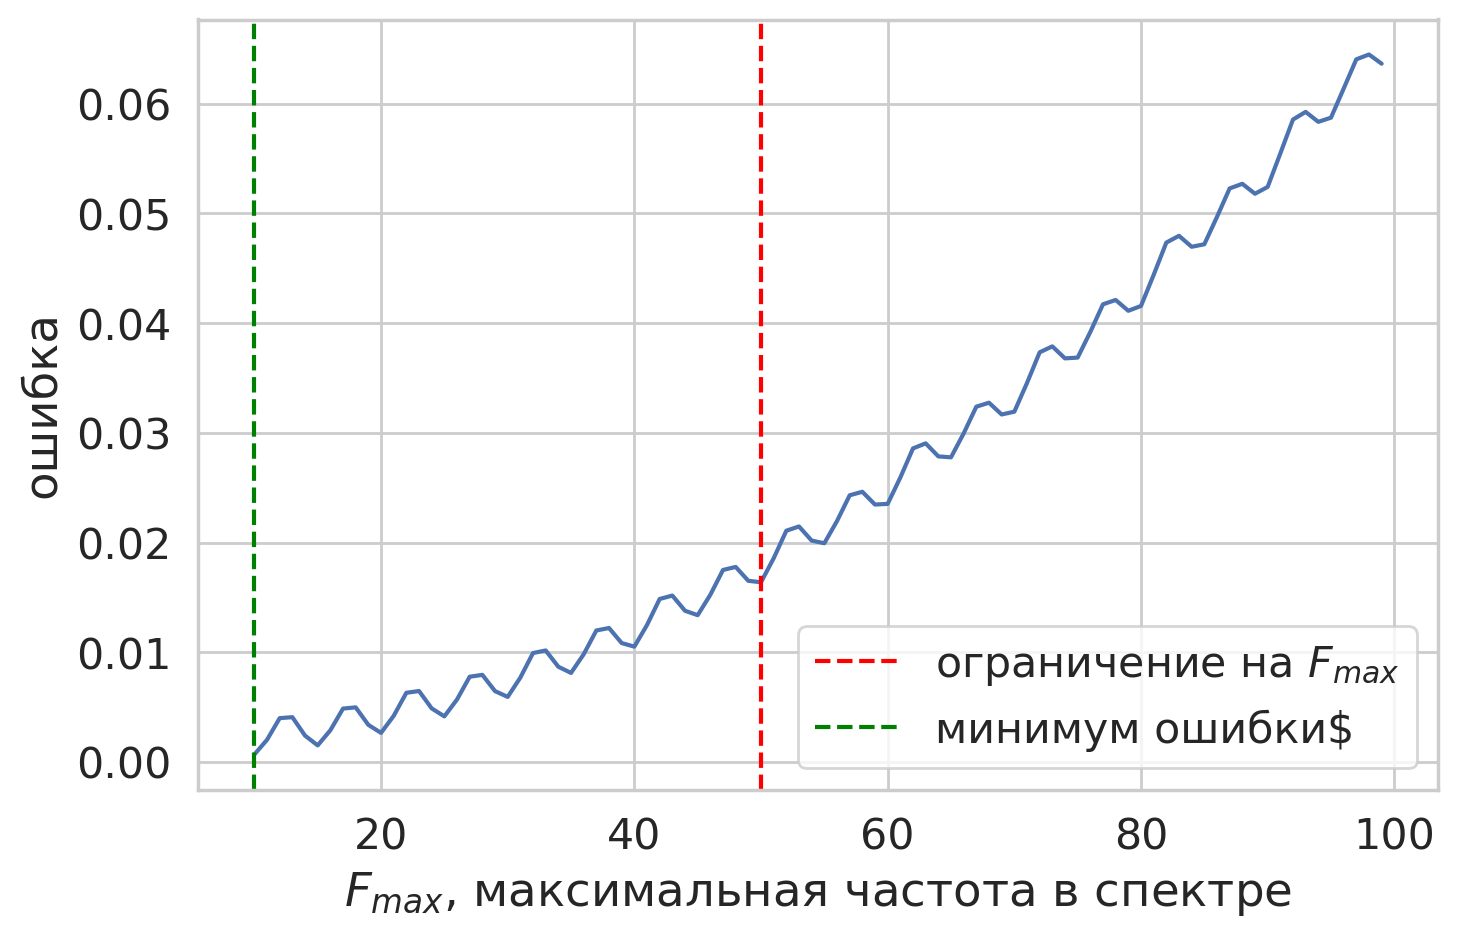

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(f_range, mse)

plt.axvline(x=100//2, color="red", linestyle="--", label=r"ограничение на $F_{max}$")
plt.axvline(x=n_range[np.argmin(mse)], color="green", linestyle="--", label=r"минимум ошибки$")

plt.ylabel("ошибка")
plt.xlabel(r"$F_{max}$, максимальная частота в спектре")

# plt.grid(False)
plt.legend()
plt.show()

**Еще одна илюстрация**.

In [ ]:
N = 1000
n_range = np.arange(10, N, 10)

error = [
    calc_fourier_reconstruct_error(lambda x: np.exp(x)+np.exp(1-x), 0, 1, N, 10**4, N_terms=n)
    for n in n_range
]

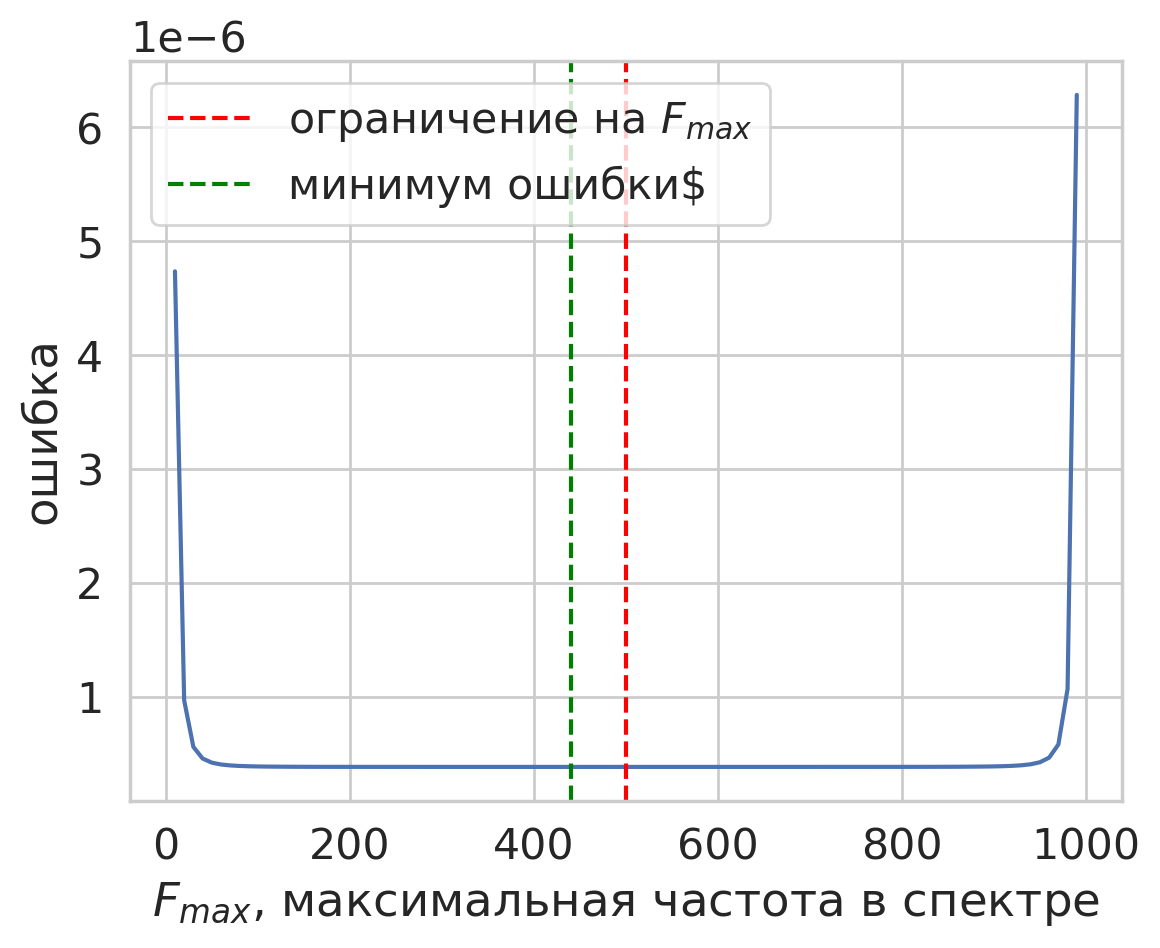

In [ ]:
plt.plot(n_range, error)

plt.axvline(x=N//2, color="red", linestyle="--", label=r"ограничение на $F_{max}$")
plt.axvline(x=n_range[np.argmin(error)], color="green", linestyle="--", label=r"минимум ошибки$")

plt.ylabel("ошибка")
plt.xlabel(r"$F_{max}$, максимальная частота в спектре")

plt.legend()
plt.show()

## Вейвлет преобразование для функции Хаара

## Интеграл от быстроосциллирующих функций